**Содержание:**

1. Теория

2. Реализация модели на numpy

3. Изучение реализации sklearn

4. Сравнение реализаций


## **1. Теория**

Решающие дерево - этот та модель, которая объединившись с другими решающими деревьями убила SVM. Само по себе дерево довольно простая модель, но она не используется одна, ведь чем глебже дерево, тем вышее её variance, то есть глубокое дерево = переобученная модель. Неглубокое дерево = высокий bias = низкое качество. Но вместе дереья создают SOTA табличных данных на данный момент. Так что их понимание необходимо.

Интуиция тут двольно простая. Давайте представим, что нам нужно выдать кредит Вове. А ещё мы знаем, что люди с семьей, с доходом не менее 100000 рублей скорее всего выплатят кредит. Доход ниже уменьшает вероятность, и лучше нам не рисковать, выдавая кредит. А вот без человек семьи с низким доходом по нашим данным обанкротится, ему выдавать не стоит. Во всех случаях.
Итак, мы смторим:
1) У Вовы есть семья? Да - идем дальше. Нет - разговор окончен.
2) У Вовы доход больше 100000 рублей? Да - выдаём, нет - гуляй, Вова.

Интуиция простая, но вот вопросы, которые сразу возникают:
1) Как определять, по какому признаку мы будем решать, то есть строить очередной узел дерева?
2) Почему мы сначала проверяем, есть ли у Вовы семья? Потому что это более важный признак. Как нам определять более важный признак?
3) Насколько глубокое дерево должно быть?
4) И много-много других.


Если бы я стал писать всё это сам, я бы слово в слово переписал лекцию Евгения Соколова [по деревьям](Decision_Trees\lecture08-trees.pdf), о том, что деревья строятся жадно, о предикатах, критериях информативности, разбиения категориальных признаков, обработке пропусков, стрижке деревьев, и даже о том, как можно представить дерево в виде линейной модели. Но зачем, ведь уже всё написано. 

## **2. Реализация модели на numpy**

В качестве критерия информативности буду использовать кросс-энтропию. Ещё популярны критерий Джини и ошибка классификации.

C:\Users\Maksim\AppData\Local\Temp\ipykernel_5048\3402181080.py:8: RuntimeWarning: divide by zero encountered in log2
  return np.array([-(np.log2(p)*p + np.log2(1-p)*(1-p))for p in probs])
C:\Users\Maksim\AppData\Local\Temp\ipykernel_5048\3402181080.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  return np.array([-(np.log2(p)*p + np.log2(1-p)*(1-p))for p in probs])


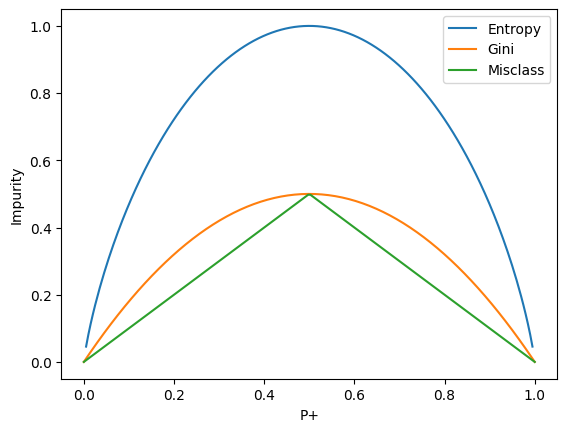

In [12]:
import numpy as np
import matplotlib.pyplot as plt
#График критериев для двух классов
def gini(probs):
    return np.array([2*p - 2*p**2 for p in probs])

def entropy(probs):
    return np.array([-(np.log2(p)*p + np.log2(1-p)*(1-p))for p in probs])

def missclassification(probs):
    return np.array([1-max(p, (1-p)) for p in probs])

probs = np.linspace(0, 1, 200)
plt.plot(probs, entropy(probs), label="Entropy")
plt.plot(probs, gini(probs), label="Gini")
plt.plot(probs, missclassification(probs), label="Misclass")
plt.xlabel("P+")
plt.ylabel("Impurity")
plt.legend()

In [18]:
#Сортировка словаря по значению
d = {
    0: 5,
    1: 10,
    2: 1,
    3: 4,
}
d = sorted(d.items(), key = lambda x: x[1])
print(d[-1][0])

1


In [68]:
#Замена np.bincount(mas)
mas = np.array([0, 1, 2, 1, 2, 1, 1, 0 , 2, 2, 2])
d = {}
for n in mas:
    d[n] = d.get(n, 0) + 1

d = dict(sorted(d.items(), key = lambda x: x[0]))
d = np.array(list(d.values()))/len(mas)
print(d)
print(np.bincount(mas)/len(mas))

[0.18181818 0.36363636 0.45454545]
[0.18181818 0.36363636 0.45454545]


In [53]:
class Node:
    def __init__(self, feature, threshold, left, right):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.rightt = right
        self.value = None
    
    def is_leaf_node(self):
        return self.value is not None
    
class CoolDecisionTree:
    def __init__(self, min_samples = 2, max_depth = 100, n_features = None):
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
    
    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)
    
    def _grow_tree(self, X, y, depth=0):
        samples, features = X.shape
        labels = len(np.unique(y))

        if (depth >= self.max_depth or labels == 1 or samples < self.min_samples):
            leaf_val = self._most_common_label(y)
            return Node(value = leaf_val)

        feat_ids = np.random.choice(features, self.n_features, replace=False)

        threshold, feature = self._best_split(X, y, feat_ids)
        

    def _best_split(self, X, y, feat_ids):
        best_gain = -1
        split_id, split_thrd = None, None

        for feat_id in feat_ids:
            X_column = X[:, feat_ids]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                gain = self._inf_gain(X_column, thr)
                if gain > best_gain:
                    best_gain = gain
                    split_id = feat_id
                    split_thrd = thr
                    
    def _inf_gain(self, X_col, y, thrd):
        parent_entropy = self._entropy(y)

        #create children

    def _entropy(self, y):
        ps = {}
        for n in y:
            ps[n] = ps.get(n, 0) + 1

        ps = dict(sorted(ps.items(), key = lambda x: x[0]))
        ps = np.array(list(ps.values()))/len(y)

        return np.sum([-p*np.log2(p) for p in ps])
    
    def _most_common_label(self,y):
        d = {}
        for l in y:
            d[l] = d.get(l, 0) + 1
        d = sorted(d.items(), key = lambda x: x[1])
        return d[-1][0]
